# joint evaluation 3

Testing expression

In [ ]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNN
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc

#set it so only device 3 is seen
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

In [2]:
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            x,y,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-11/17-59-55-471925/checkpoints/last.ckpt'
evals = Evals(ckpt_path)

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [3]:
evals.encoder

JointCNN(
  (conv1): Sequential(
    (0): Conv1d(6, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(2, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (out): Linear(in_features=256, out_features=256, bias=True)
)

In [4]:
evals.backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Transpose()
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (norm): RMSNorm()
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
              (act): SiLU()
              (x_proj): Linear(in_features=512, out_features=48, bias=False)
              (dt_proj): Linear(in_features=16, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=256, bias=False)
            )
            (mamba_rev): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
           

In [5]:
evals.decoder

EnformerDecoder(
  (output_transform): Linear(in_features=256, out_features=1, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
  (softplus): Softplus(beta=1, threshold=20)
)

In [6]:
out = evals.dataset[0]

In [7]:
len(out)

2

In [8]:
print(out[0][0].shape, out[0][1].shape)
print(out[1][0].shape, out[1][1].shape, out[1][2].shape)
#is it an issue to not be a np array?

torch.Size([6, 524288]) torch.Size([2, 524288])
torch.Size([524288, 6]) torch.Size([524288, 2]) (896, 1)


In [9]:
import torch.nn.functional as F
F.poisson_nll_loss(torch.rand((896,1)), out[1][2])

TypeError: poisson_nll_loss(): argument 'target' (position 2) must be Tensor, not numpy.ndarray

In [10]:
#let's see if we use a dataloader
from torch.utils.data import DataLoader
loader = DataLoader(evals.dataset, batch_size=1, shuffle=False, num_workers=0)
out = next(iter(loader))
print(out[0][0].shape, out[0][1].shape)
print(out[1][0].shape, out[1][1].shape, out[1][2].shape)

torch.Size([1, 6, 524288]) torch.Size([1, 2, 524288])
torch.Size([1, 524288, 6]) torch.Size([1, 524288, 2]) torch.Size([1, 896, 1])


In [ ]:
#so it turns it into a torch tensor, pretty good! and it's float 32 which is perfect!
out[1][2].dtype

torch.float32

In [2]:
#edit evals class
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask,exp) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            (x,y),(seq_unmask,acc_unmask,exp) = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
        
        return x1, exp
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-11/17-59-55-471925/checkpoints/last.ckpt'
evals = Evals(ckpt_path)
out = evals(0)

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [15]:
out[0].shape, out[1].shape

(torch.Size([1, 896, 1]), (896, 1))

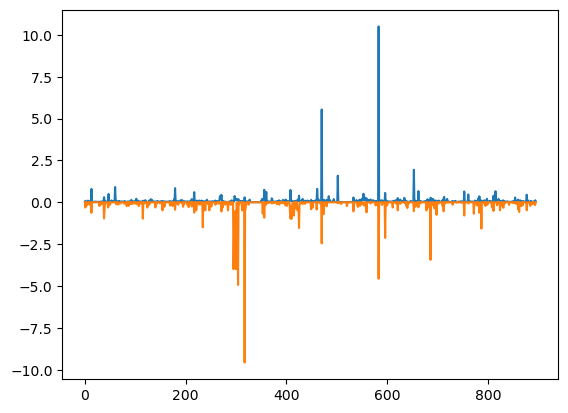

In [19]:
import matplotlib.pyplot as plt
plt.plot(out[0][0,:,0].cpu().numpy(), label='pred')
plt.plot(-out[1][:,0], label='exp')

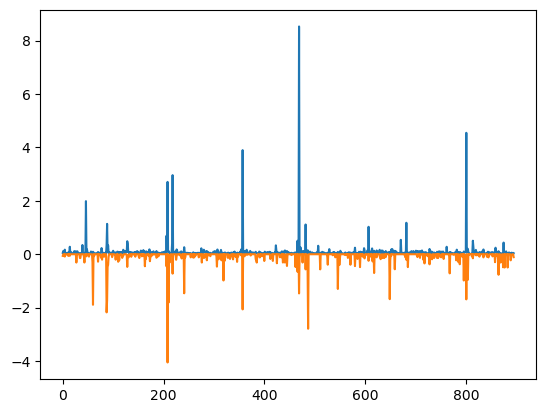

In [20]:
for i in range(10):
    out = evals(i) #roughly 2 second per I guess?
plt.plot(out[0][0,:,0].cpu().numpy(), label='pred')
plt.plot(-out[1][:,0], label='exp')

In [21]:
from tqdm import tqdm
for i in tqdm(range(10)):
    out = evals(i) #roughly 2 second per I guess?

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


In [22]:
#what if we batch it
from torch.utils.data import DataLoader
loader = DataLoader(evals.dataset, batch_size=8, shuffle=False, num_workers=0)
for i, data in tqdm(enumerate(loader)):
    out = evals(data) #roughly 2 second per I guess?
    if i == 0:
        break

0it [00:06, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [6]:
#wait the slow part is loading the data, let's preload it!
evals = Evals(ckpt_path, load_data=True)

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [ ]:
for i in tqdm(range(10)):
    out = evals(i) #roughly 1 s per I guess, can batch it tho

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [29]:
data[0][0].shape

torch.Size([8, 6, 524288])

In [37]:
#and now batched
loader = DataLoader(evals.dataset, batch_size=8, shuffle=False, num_workers=0)
for i, data in tqdm(enumerate(loader)):
    inp = (data[0], data[1])
    out = evals(data=data) #roughly 1 s per I guess, can batch it tho
    if i == 0:
        break

0it [00:01, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 0 has a total capacty of 79.11 GiB of which 2.19 GiB is free. Process 3508541 has 2.16 GiB memory in use. Including non-PyTorch memory, this process has 74.72 GiB memory in use. Of the allocated memory 69.52 GiB is allocated by PyTorch, and 4.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
#let's do batch size of 4
from torch.utils.data import DataLoader
loader = DataLoader(evals.dataset, batch_size=4, shuffle=False, num_workers=0)
for i, data in tqdm(enumerate(loader)):
    inp = (data[0], data[1])
    out = evals(data=data) #roughly 1 s per I guess, can batch it tho
    if i == 0:
        break

0it [00:00, ?it/s]


In [8]:
for i, data in tqdm(enumerate(loader)):
    inp = (data[0], data[1])
    out = evals(data=data)
    if i == 10:
        break
#relatively quick! So we 

9it [00:34,  3.80s/it]


KeyboardInterrupt: 

In [ ]:
#now find the output of th emodel so we can save it!

# now we have the outputs, let's load them!

In [1]:
#first verify the targets are the same
import numpy as np
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets.npy')
t1.shape, t2.shape

((1937, 896), (1937, 896))

In [2]:
np.allclose(t1, t2)

True

In [3]:
#now verify it with the saved values
cage_data = '/data1/lesliec/sarthak/data/enformer/data/GM12878CAGE.npz'
cage = np.load(cage_data)
cage['test'].shape

(1937, 896, 1)

In [4]:
np.allclose(cage['test'][:,:,0], t1)

True

In [5]:
#ok so the targets are good, let's test the outputs
p1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_predictions.npy')
p2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_predictions_conv.npy')
print(p1.shape, p2.shape)

(1937, 896) (1937, 896)


In [6]:
#let's also load in the true enformer outputs
enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer.shape

(1937, 896, 5313)

In [7]:
enformer.nbytes/1e9 #almost 40 GB!!

36.883951104

In [8]:
enf = enformer[:,:,5110]
enf.shape

(1937, 896)

In [ ]:
#now these are all the same! let's just do a spearman correlation
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

p1_s = []
p2_s = []
enf_s = []
p1_p = []
p2_p = []
enf_p = []

for i in tqdm(range(enf.shape[0])): #now correlate all with the true targets, stored in variable t1, so correlate enf with t1, p1 with t1 etc
    p1_s.append(spearmanr(p1[i], t1[i])[0])
    p2_s.append(spearmanr(p2[i], t1[i])[0])
    enf_s.append(spearmanr(enf[i], t1[i])[0])
    
    p1_p.append(pearsonr(p1[i], t1[i])[0])
    p2_p.append(pearsonr(p2[i], t1[i])[0])
    enf_p.append(pearsonr(enf[i], t1[i])[0])
p1_s = np.array(p1_s)
p2_s = np.array(p2_s)
enf_s = np.array(enf_s)
p1_p = np.array(p1_p)
p2_p = np.array(p2_p)
enf_p = np.array(enf_p)

print(p1_s.mean(), p2_s.mean(), enf_s.mean())
print(p1_p.mean(), p2_p.mean(), enf_p.mean())
    

0.3825015112789453 0.37389345306755206 0.3874371096891748
0.6127485677753474 0.6267588678683128 0.6259863628202122


In [13]:
#see if any nans in any of these
print(np.isnan(p1_s).sum(), np.isnan(p2_s).sum(), np.isnan(enf_s).sum())
print(np.isnan(p1_p).sum(), np.isnan(p2_p).sum(), np.isnan(enf_p).sum())

0 0 0
0 0 0


/tmp/ipykernel_999637/1554100619.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Model", y="Spearman Correlation", data=df_long, inner="quartile", palette="pastel")


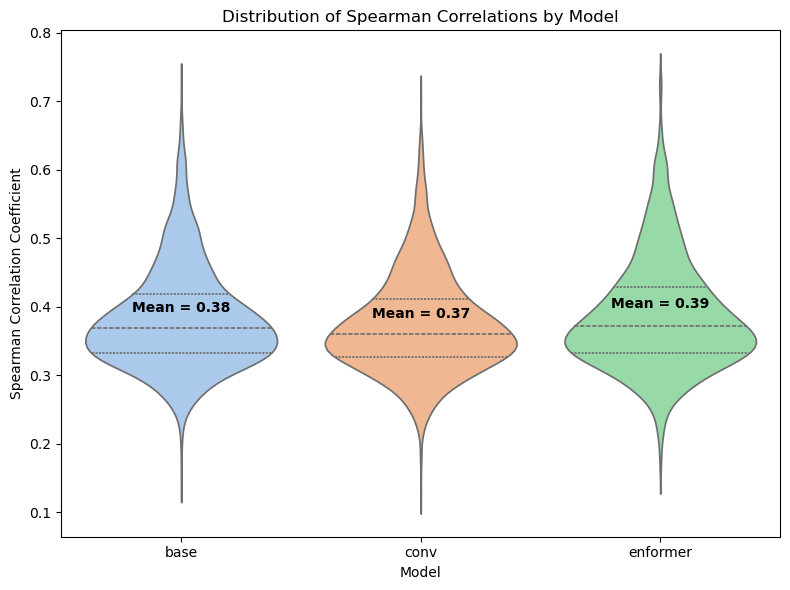

In [18]:
#let's do a violin plot!
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
correlation_data = pd.DataFrame({
    'base': p1_s,
    'conv': p2_s,
    'enformer': enf_s
})

# Melt the DataFrame to long format for easier plotting with Seaborn.
df_long = correlation_data.melt(var_name="Model", value_name="Spearman Correlation")

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Model", y="Spearman Correlation", data=df_long, inner="quartile", palette="pastel")

# Optionally, overlay a swarm plot or pointplot to show the mean or distribution
# sns.pointplot(x="Model", y="Spearman Correlation", data=df_long, dodge=0.5, join=False, color='black', markers='d', scale=0.75)

means = correlation_data.mean()
positions = [0, 1, 2]
for pos, model in zip(positions, ['base', 'conv', 'enformer']):
    plt.text(pos, means[model] + 0.01, f"Mean = {means[model]:.2f}",
             horizontalalignment='center', color='black', weight='semibold')

plt.title("Distribution of Spearman Correlations by Model")
plt.xlabel("Model")
plt.ylabel("Spearman Correlation Coefficient")
plt.tight_layout()
plt.show()

/tmp/ipykernel_999637/375522855.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Model", y="Pearson Correlation", data=df_long, inner="quartile", palette="pastel")


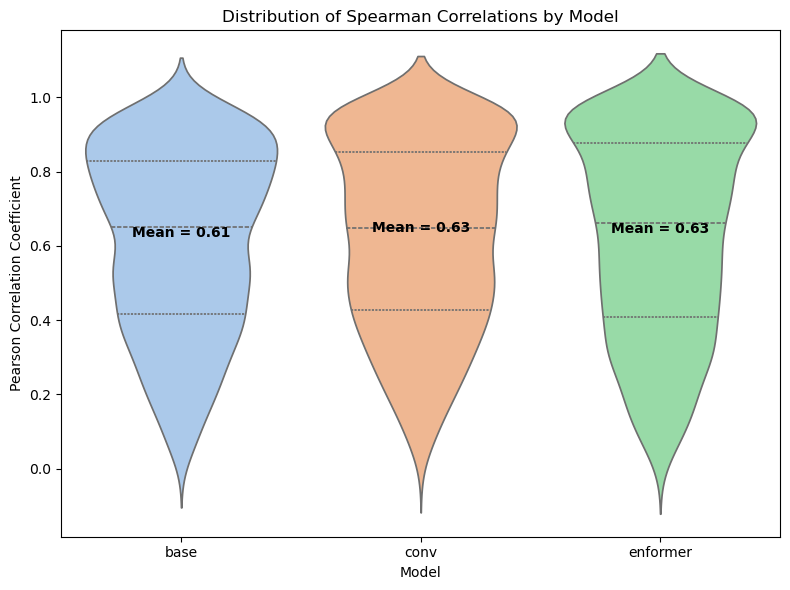

In [20]:
correlation_data = pd.DataFrame({
    'base': p1_p,
    'conv': p2_p,
    'enformer': enf_p
})

# Melt the DataFrame to long format for easier plotting with Seaborn.
df_long = correlation_data.melt(var_name="Model", value_name="Pearson Correlation")

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Model", y="Pearson Correlation", data=df_long, inner="quartile", palette="pastel")

# Optionally, overlay a swarm plot or pointplot to show the mean or distribution
# sns.pointplot(x="Model", y="Spearman Correlation", data=df_long, dodge=0.5, join=False, color='black', markers='d', scale=0.75)

means = correlation_data.mean()
positions = [0, 1, 2]
for pos, model in zip(positions, ['base', 'conv', 'enformer']):
    plt.text(pos, means[model] + 0.01, f"Mean = {means[model]:.2f}",
             horizontalalignment='center', color='black', weight='semibold')

plt.title("Distribution of Spearman Correlations by Model")
plt.xlabel("Model")
plt.ylabel("Pearson Correlation Coefficient")
plt.tight_layout()
plt.show()

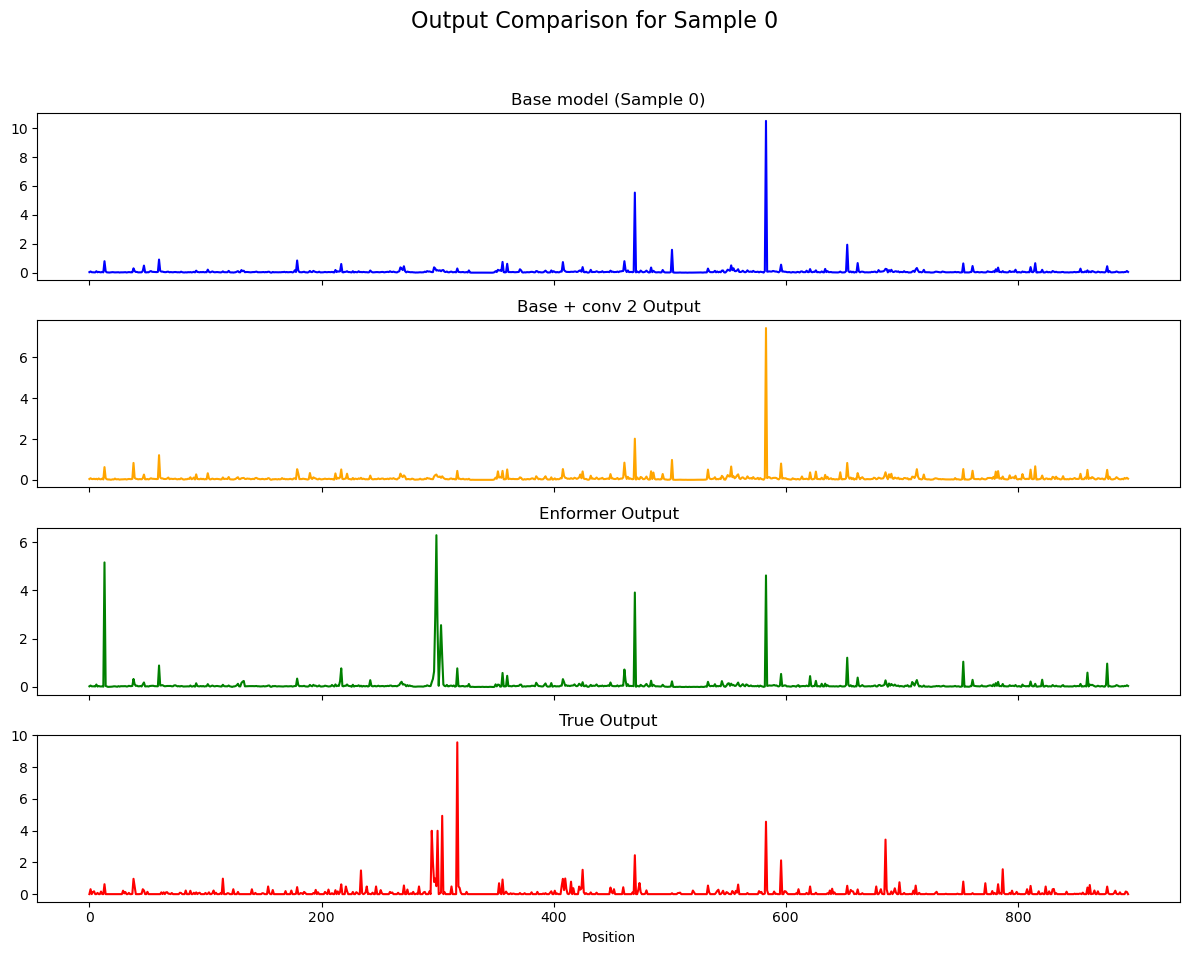

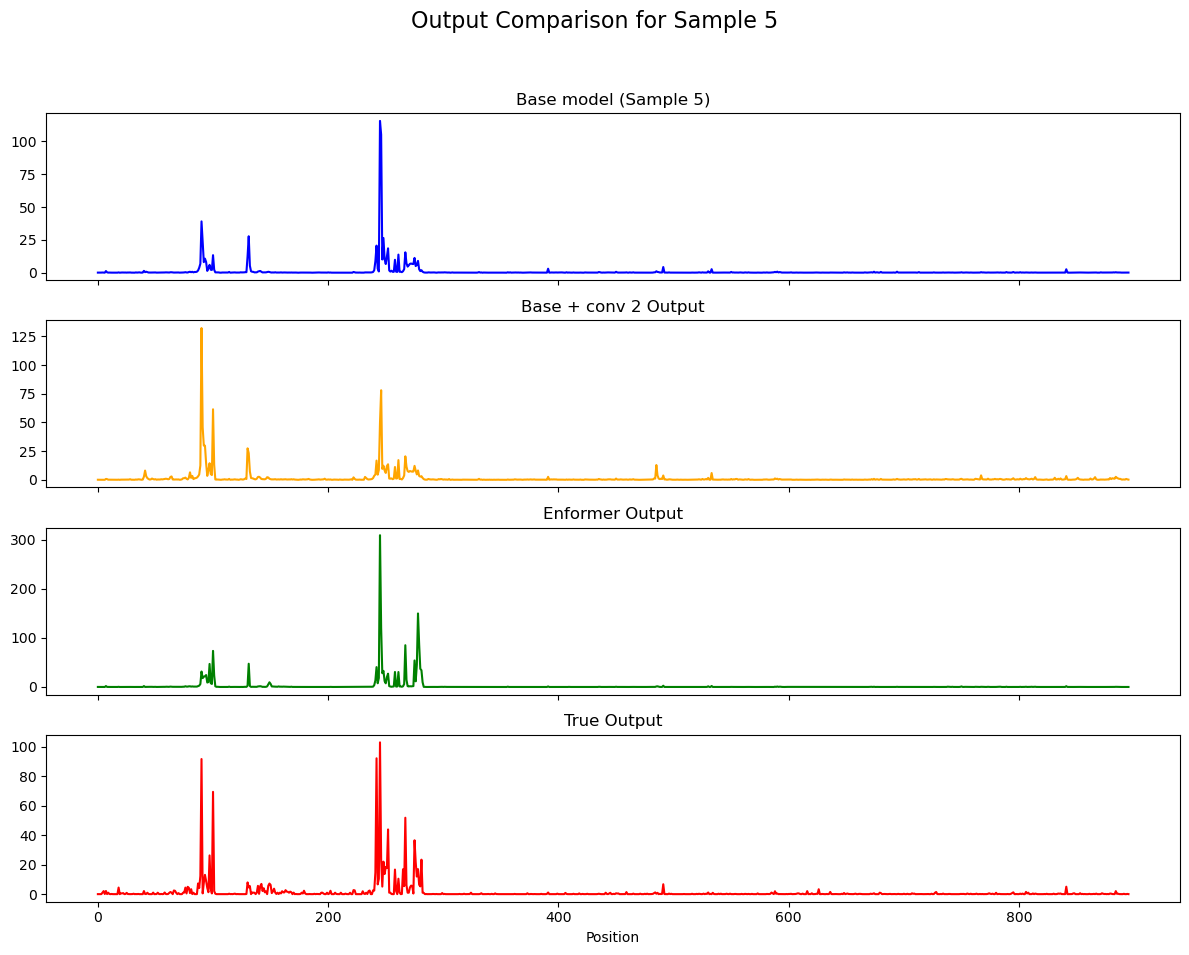

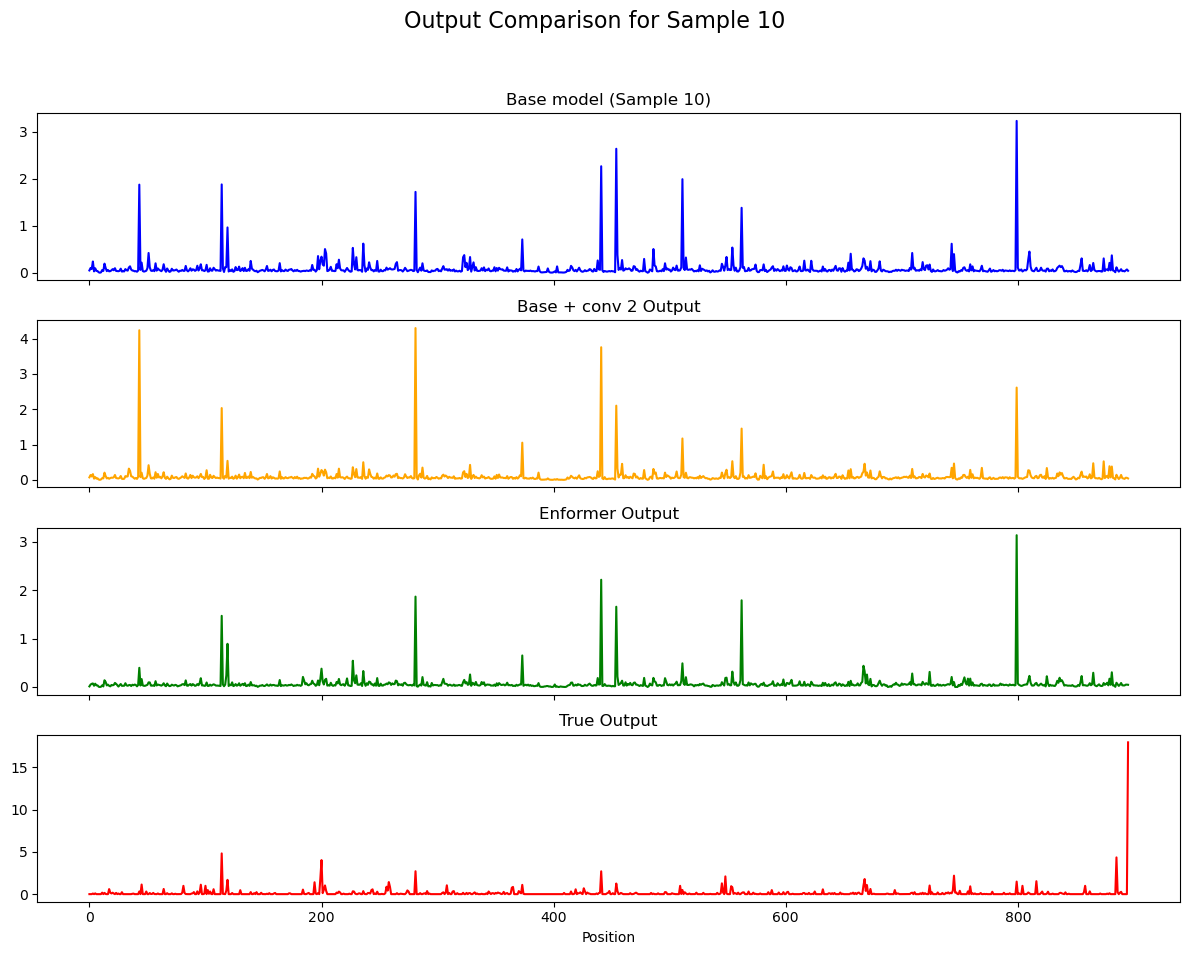

In [23]:
#and let's just plot some random tracks to compare and see how similar/different the models are!
import numpy as np
import matplotlib.pyplot as plt

def plot_output_tracks(sample_indices, model1_outputs, model2_outputs, model3_outputs, true_outputs):
    """
    Given a list of sample indices, this function plots the output tracks from three models
    along with the true outputs. Each sample is plotted in a separate figure with 4 stacked subplots.
    
    Parameters:
    - sample_indices: list of integers indicating which samples to plot.
    - model1_outputs: numpy array of shape (num_samples, output_length) for Model 1.
    - model2_outputs: numpy array of shape (num_samples, output_length) for Model 2.
    - model3_outputs: numpy array of shape (num_samples, output_length) for Model 3.
    - true_outputs: numpy array of shape (num_samples, output_length) for the true targets.
    """
    
    # Create an x-axis based on the output length (assuming all arrays have the same shape)
    positions = np.arange(model1_outputs.shape[1])
    
    for idx in sample_indices:
        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        
        # Plot Model 1 output
        axes[0].plot(positions, model1_outputs[idx], label='Model 1', color='blue')
        axes[0].set_title(f"Base model (Sample {idx})")
        # axes[0].legend()
        
        # Plot Model 2 output
        axes[1].plot(positions, model2_outputs[idx], label='Model 2', color='orange')
        axes[1].set_title("Base + conv 2 Output")
        # axes[1].legend()
        
        # Plot Model 3 output
        axes[2].plot(positions, model3_outputs[idx], label='Model 3', color='green')
        axes[2].set_title("Enformer Output")
        # axes[2].legend()
        
        # Plot True output
        axes[3].plot(positions, true_outputs[idx], label='True Output', color='red')
        axes[3].set_title("True Output")
        axes[3].set_xlabel("Position")
        # axes[3].legend()
        
        fig.suptitle(f"Output Comparison for Sample {idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage:
# sample_ids = [0, 5, 10]  # list of sample indices you want to plot
# plot_output_tracks(sample_ids, p1, p2, enf, t1)
sample_ids = [0, 5, 10]  # list of sample indices you want to plot
plot_output_tracks(sample_ids, p1, p2, enf, t1)

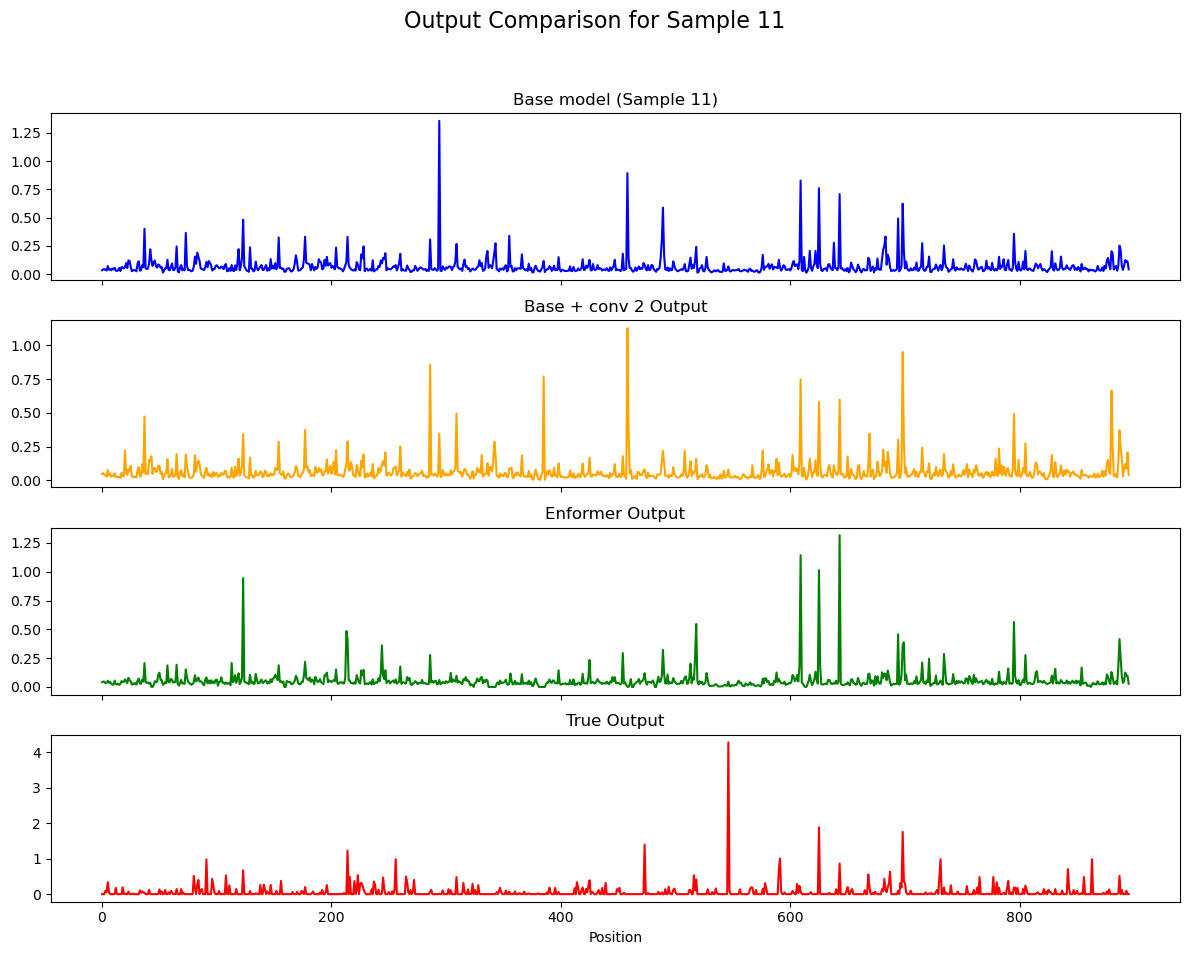

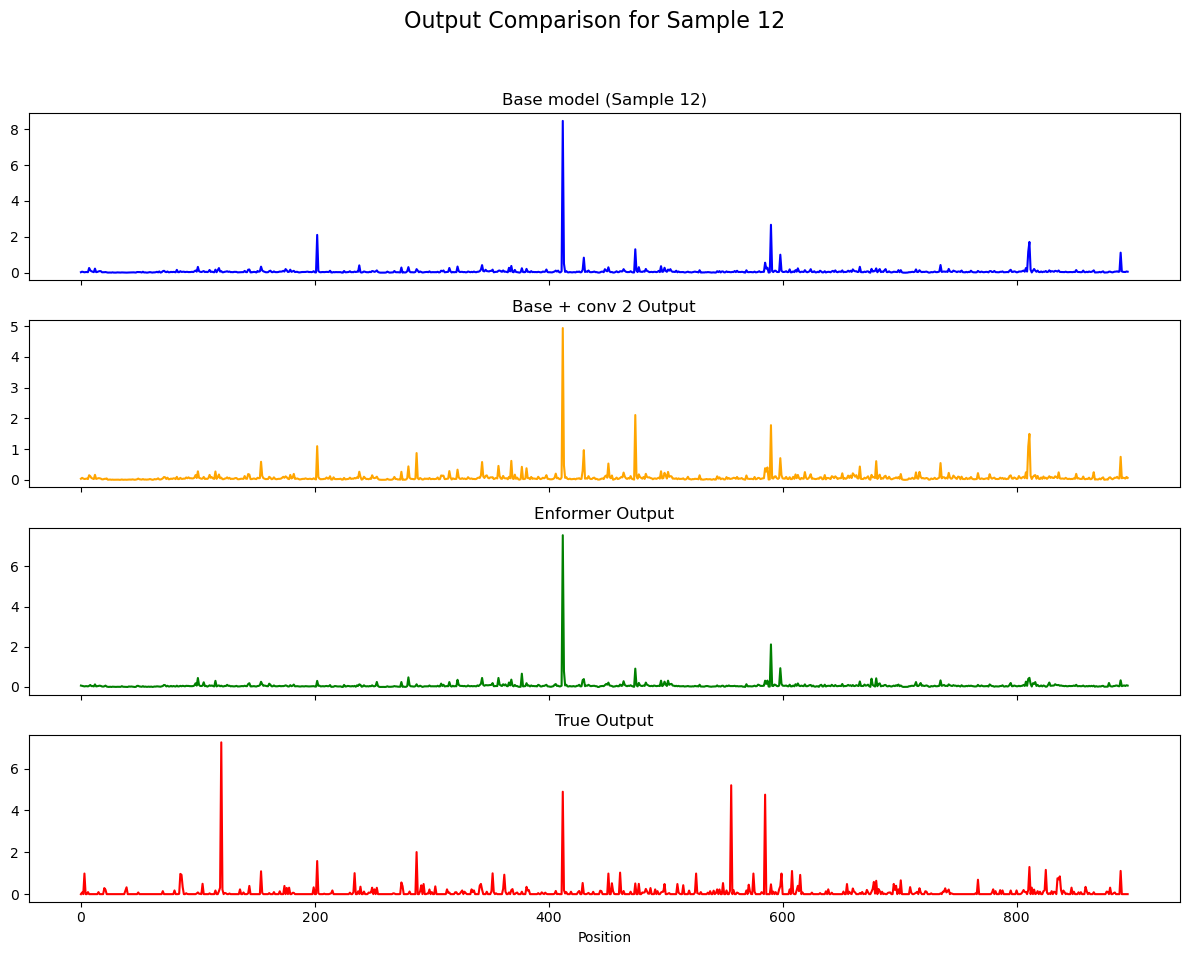

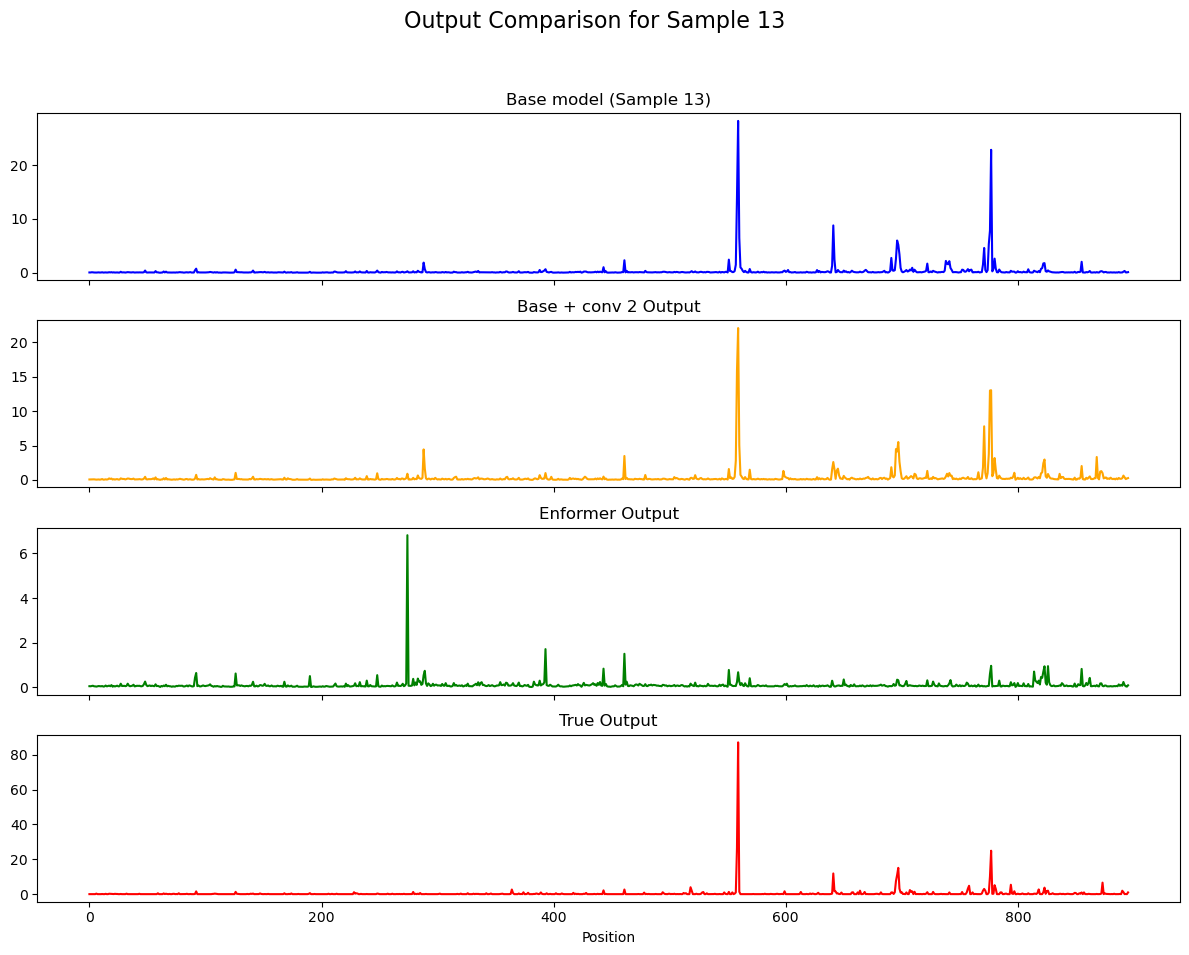

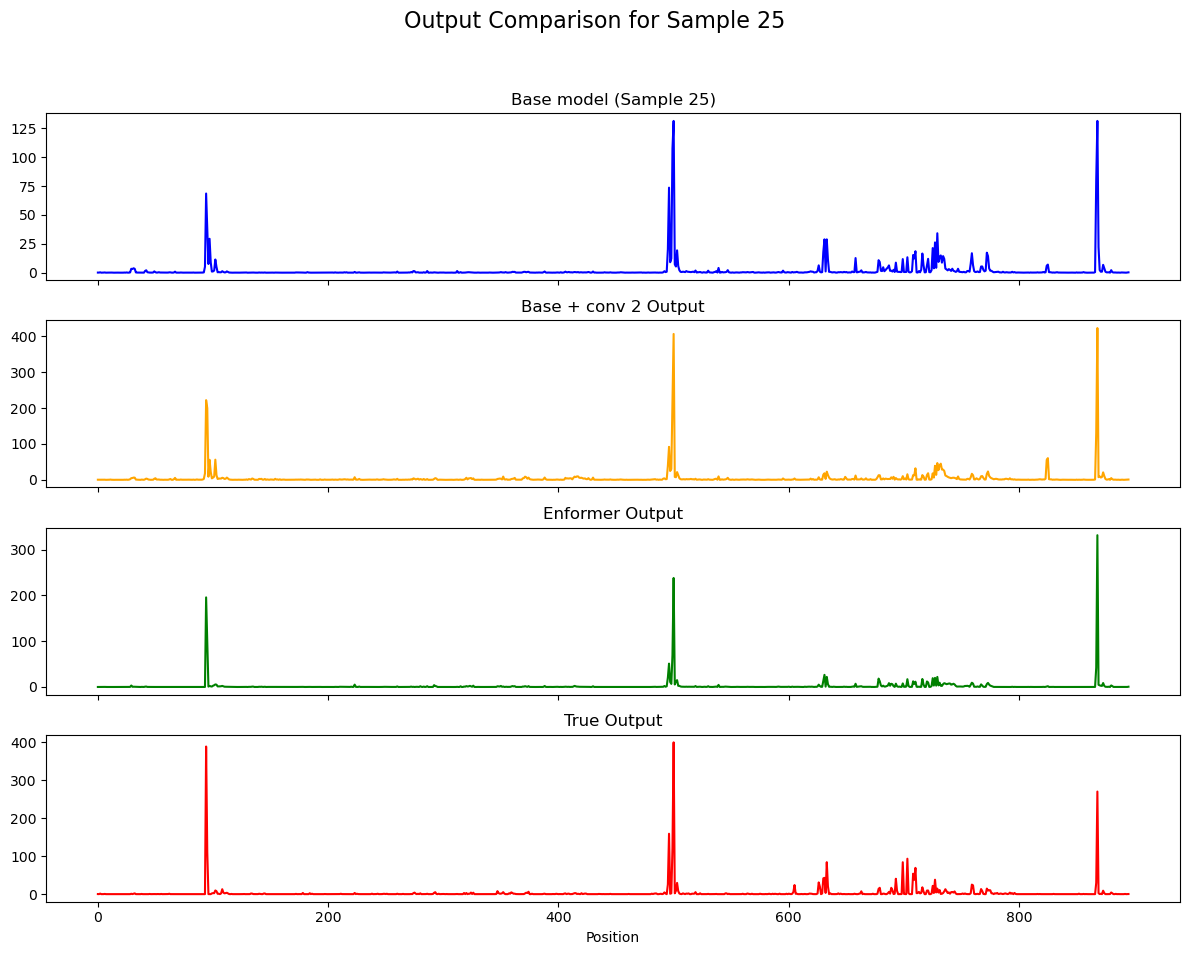

In [24]:
sample_ids = [11,12,13,25]  # list of sample indices you want to plot
plot_output_tracks(sample_ids, p1, p2, enf, t1)

# and doing it for more models

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

model_names = ['GM12878_base_more_train_predictions.npy', 'GM12878_no_mlm_predictions.npy', 'GM12878_no_finetune_predictions.npy', 'GM12878_base_predictions_conv.npy', 'enformer']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
    print(preds[model_name].shape)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)


In [12]:
#now let's do the correlations
from scipy.stats import spearmanr, pearsonr

t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')

spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in range(arr.shape[0]):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

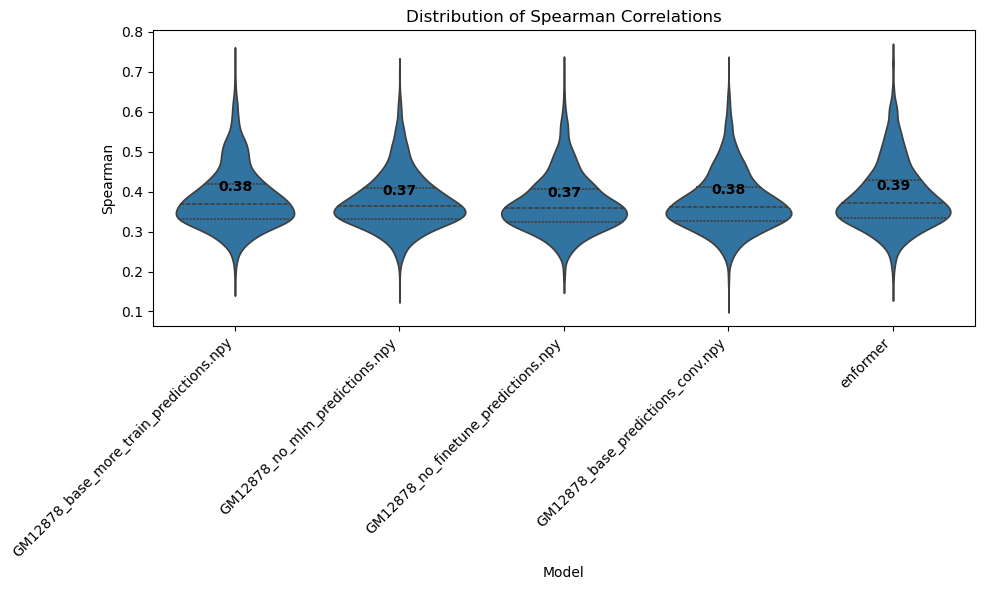

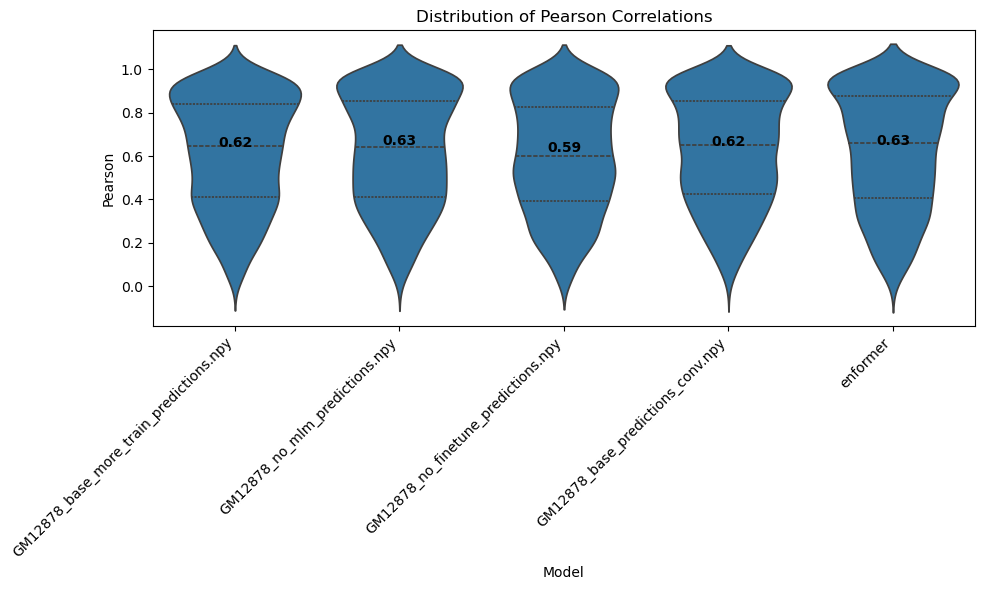

In [15]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    # annotate means
    means = df_long.groupby("Model")[metric].mean()
    for idx, (model, mval) in enumerate(means.items()):
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

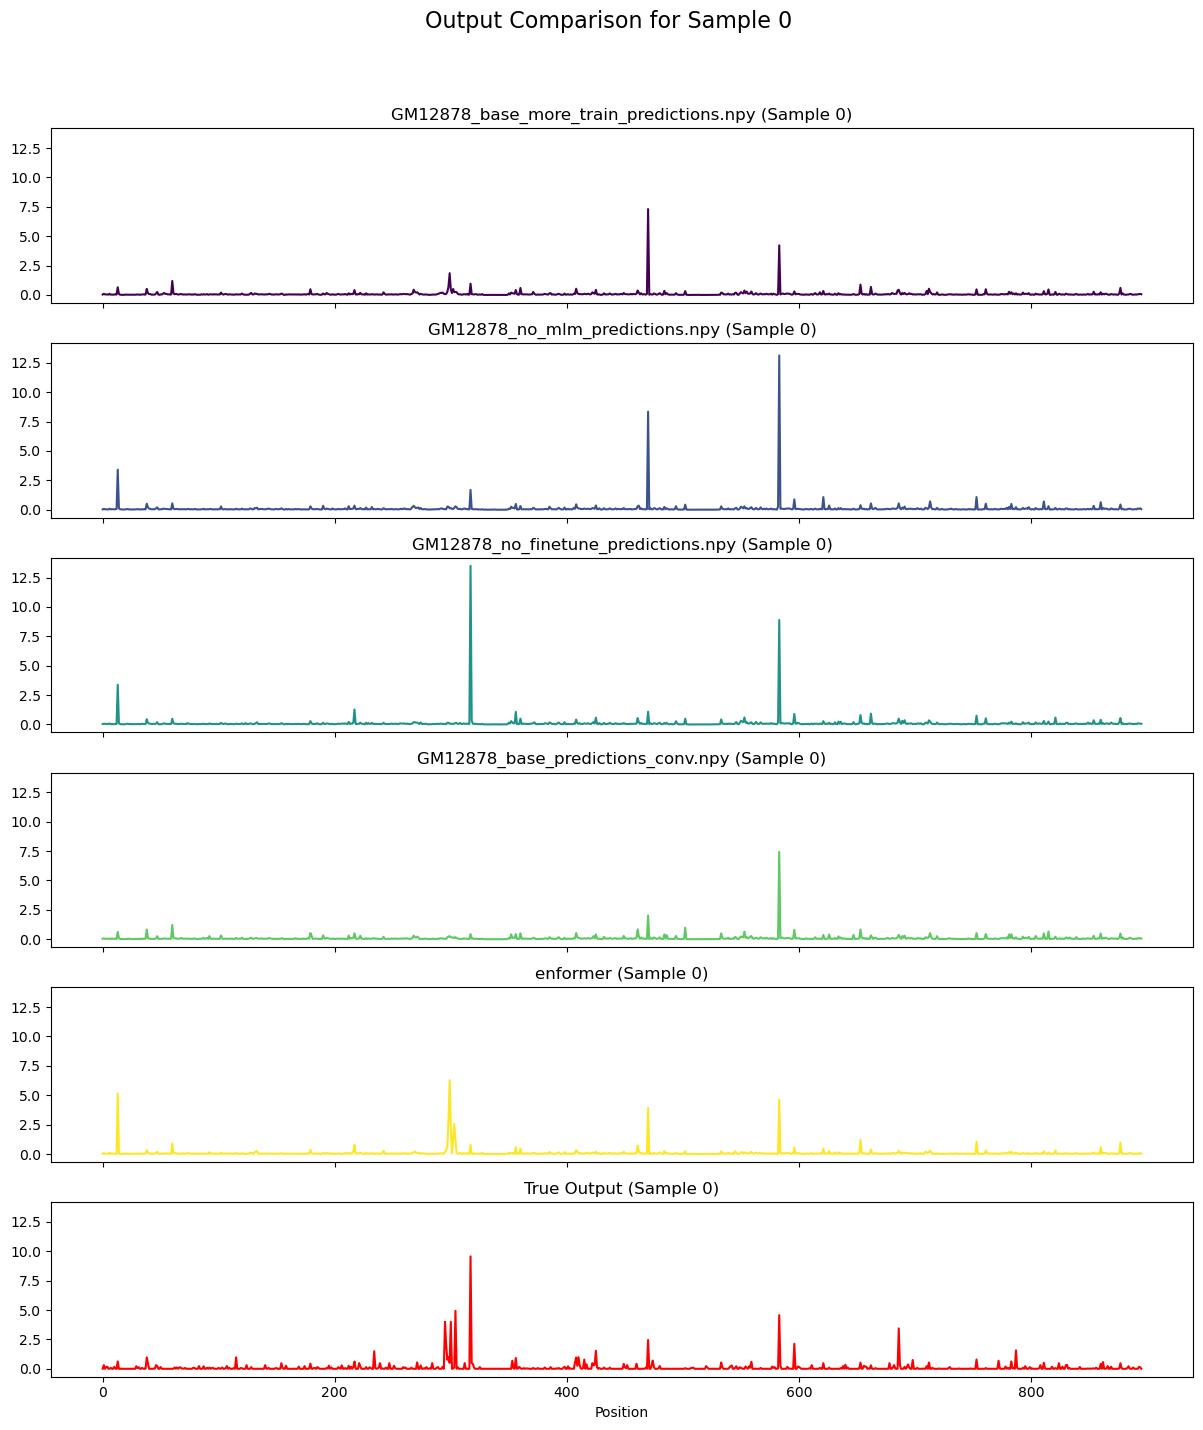

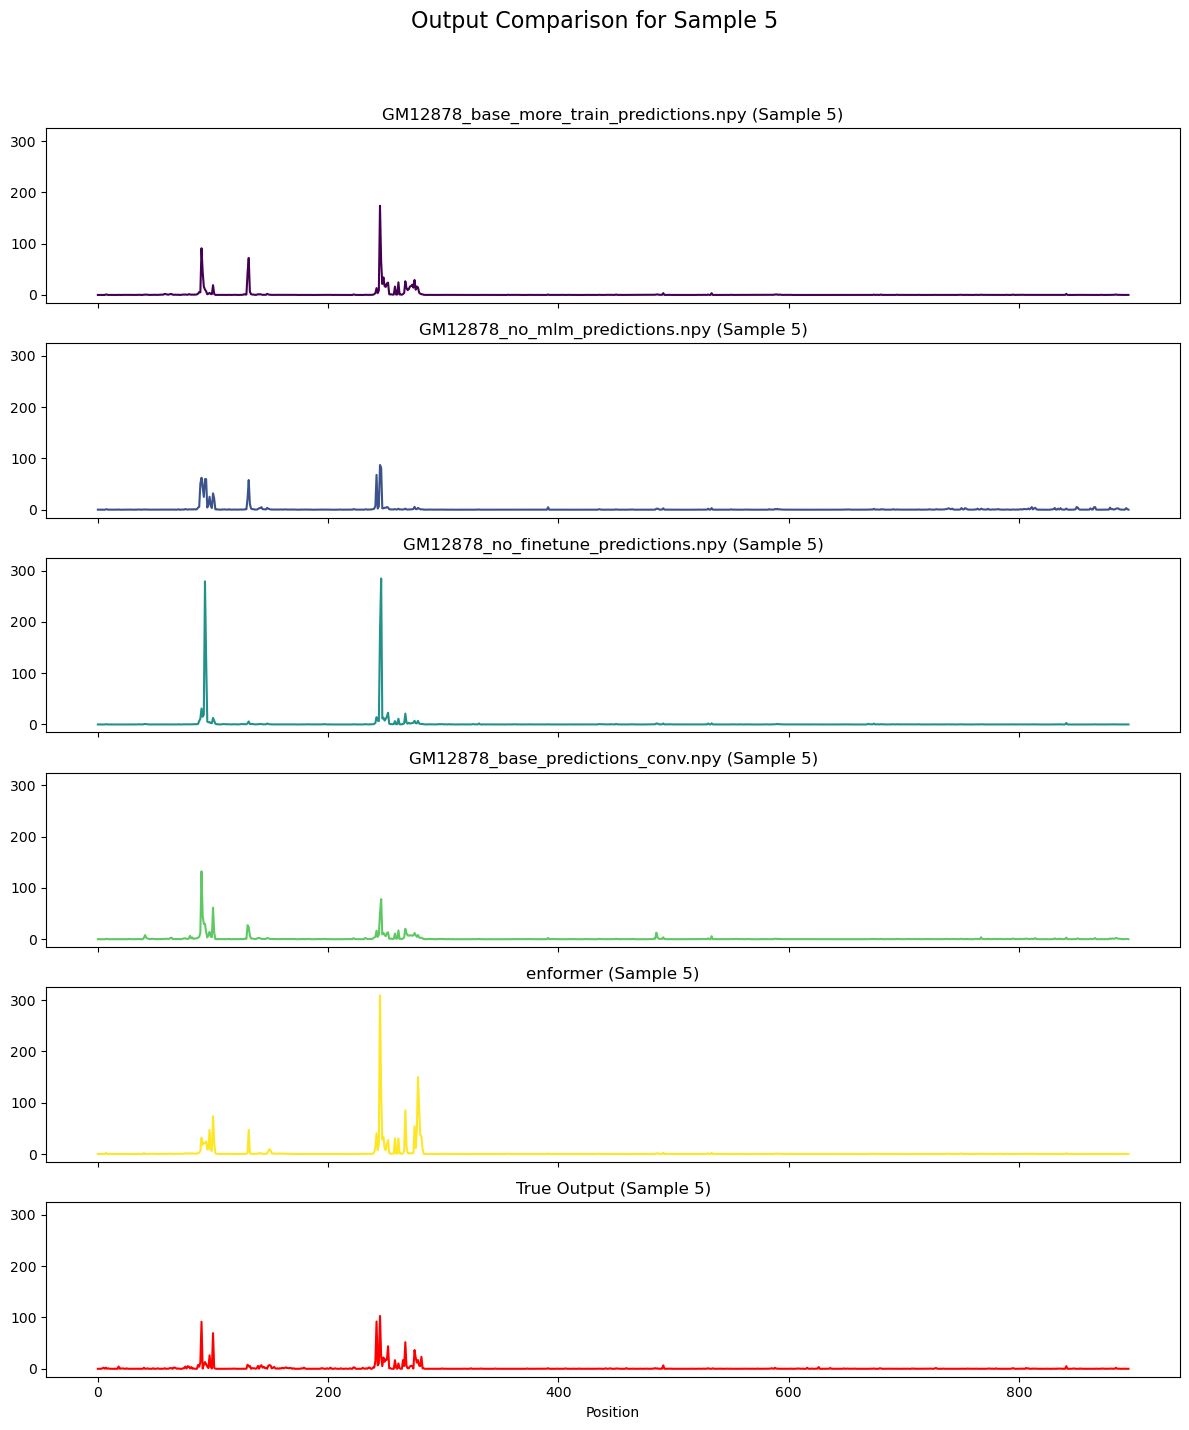

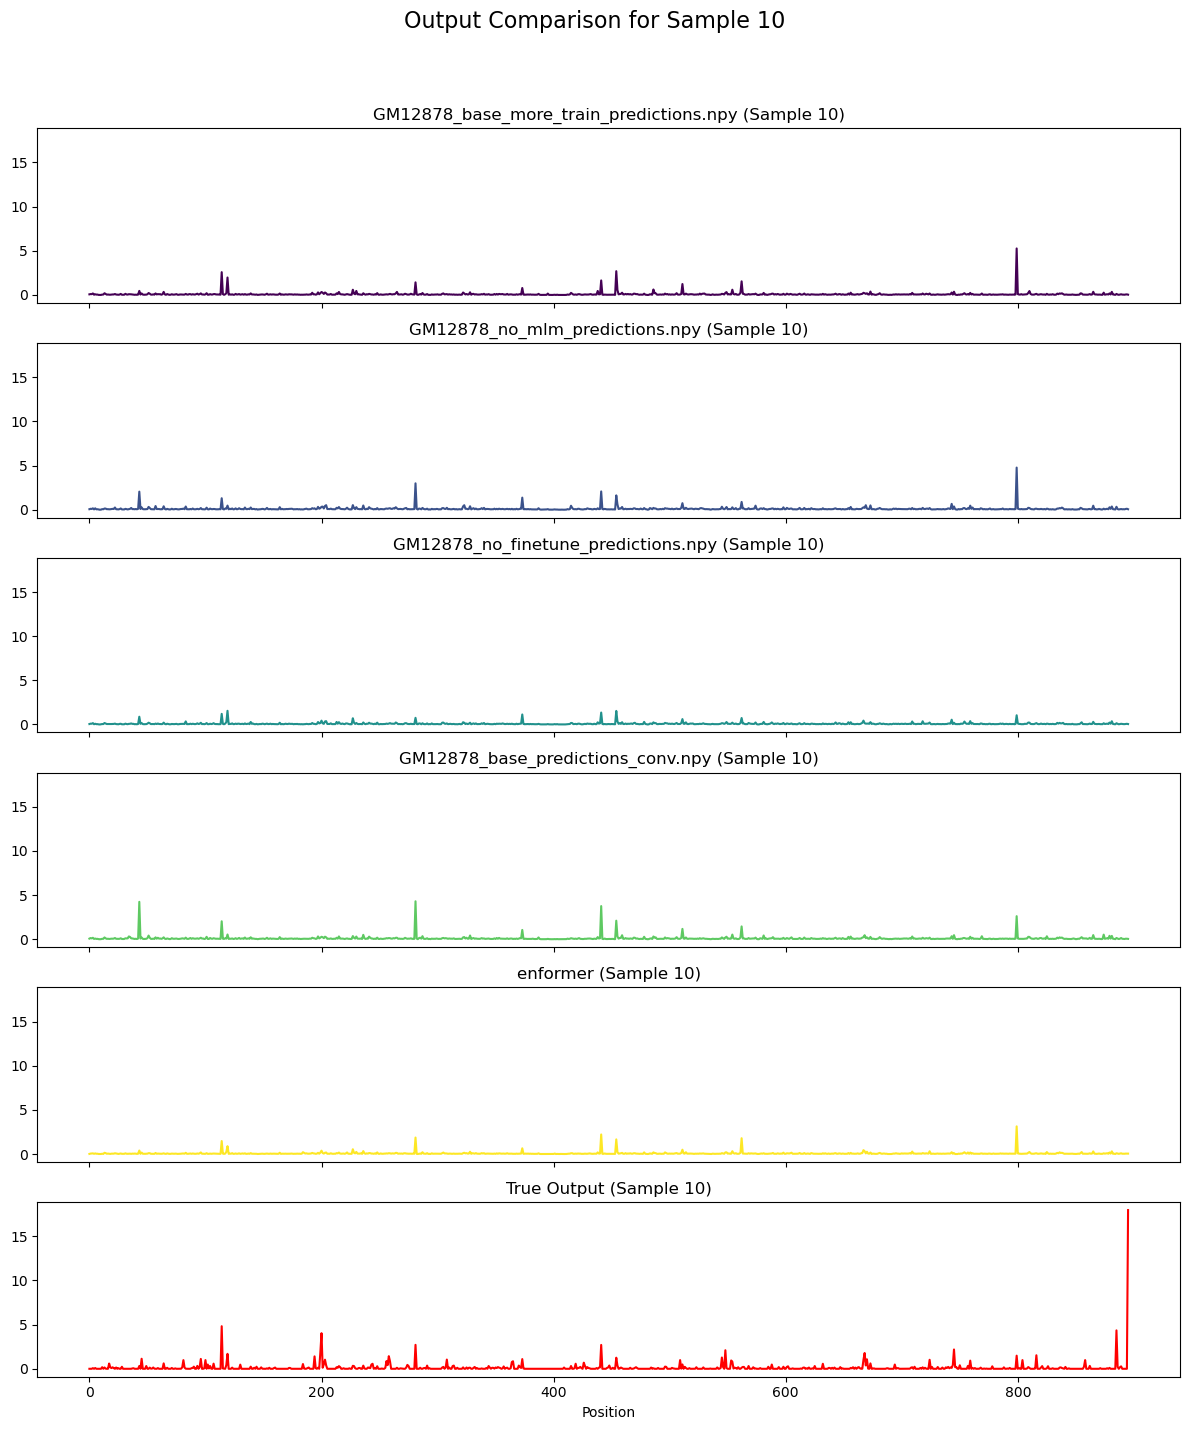

In [19]:
#now we can look at some sample plots
import numpy as np
import matplotlib.pyplot as plt

def plot_output_tracks(sample_indices, model_outputs: dict, true_outputs: np.ndarray, true_name: str = "True Output"):
    """
    Plots the output tracks for an arbitrary number of models plus the true outputs,
    with consistent y-axis limits per sample (bottom ~0, top determined by that sample).
    
    Parameters
    ----------
    sample_indices : list of int
        Which samples (rows) to plot.
    model_outputs : dict[str, np.ndarray]
        Dict mapping model name → array of shape (n_samples, output_length).
    true_outputs : np.ndarray
        Array of shape (n_samples, output_length) with the ground truth.
    true_name : str, optional
        Title for the true-output subplot (default "True Output").
    """
    # sanity check: all model arrays + true must have same shape
    shapes = {arr.shape for arr in model_outputs.values()} | {true_outputs.shape}
    if len(shapes) != 1:
        raise ValueError(f"All inputs must have the same shape; got {shapes}")
    n_samples, output_len = true_outputs.shape

    positions = np.arange(output_len)
    n_models  = len(model_outputs)
    n_rows    = n_models + 1
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_models))

    for idx in sample_indices:
        if idx < 0 or idx >= n_samples:
            raise IndexError(f"Sample index {idx} is out of bounds (0–{n_samples-1})")

        # gather all values for this sample to compute shared y-limits
        sample_vals = [arr[idx] for arr in model_outputs.values()]
        sample_vals.append(true_outputs[idx])
        all_vals = np.concatenate(sample_vals)
        y_max = np.nanmax(all_vals)
        y_min = np.nanmin(all_vals)

        # compute a small margin (5% of range)
        data_range = y_max - y_min
        margin = data_range * 0.05 if data_range != 0 else y_max * 0.05 or 1.0

        # bottom slightly below zero (or below min if negative), top above max
        lower = min(0, y_min) - margin
        upper = y_max + margin

        fig, axes = plt.subplots(n_rows, 1, figsize=(12, 2.5 * n_rows), sharex=True)
        if n_rows == 1:
            axes = [axes]

        # plot each model
        for row, (name, arr) in enumerate(model_outputs.items()):
            ax = axes[row]
            ax.plot(positions, arr[idx], label=name, color=colors[row])
            ax.set_title(f"{name} (Sample {idx})")
            ax.set_ylim(lower, upper)

        # plot true output
        ax = axes[-1]
        ax.plot(positions, true_outputs[idx], label=true_name, color='red')
        ax.set_title(f"{true_name} (Sample {idx})")
        ax.set_xlabel("Position")
        ax.set_ylim(lower, upper)

        fig.suptitle(f"Output Comparison for Sample {idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
# Example usage:
sample_ids = [0, 5, 10]  # list of sample indices you want to plot
plot_output_tracks(sample_ids, preds, t1)

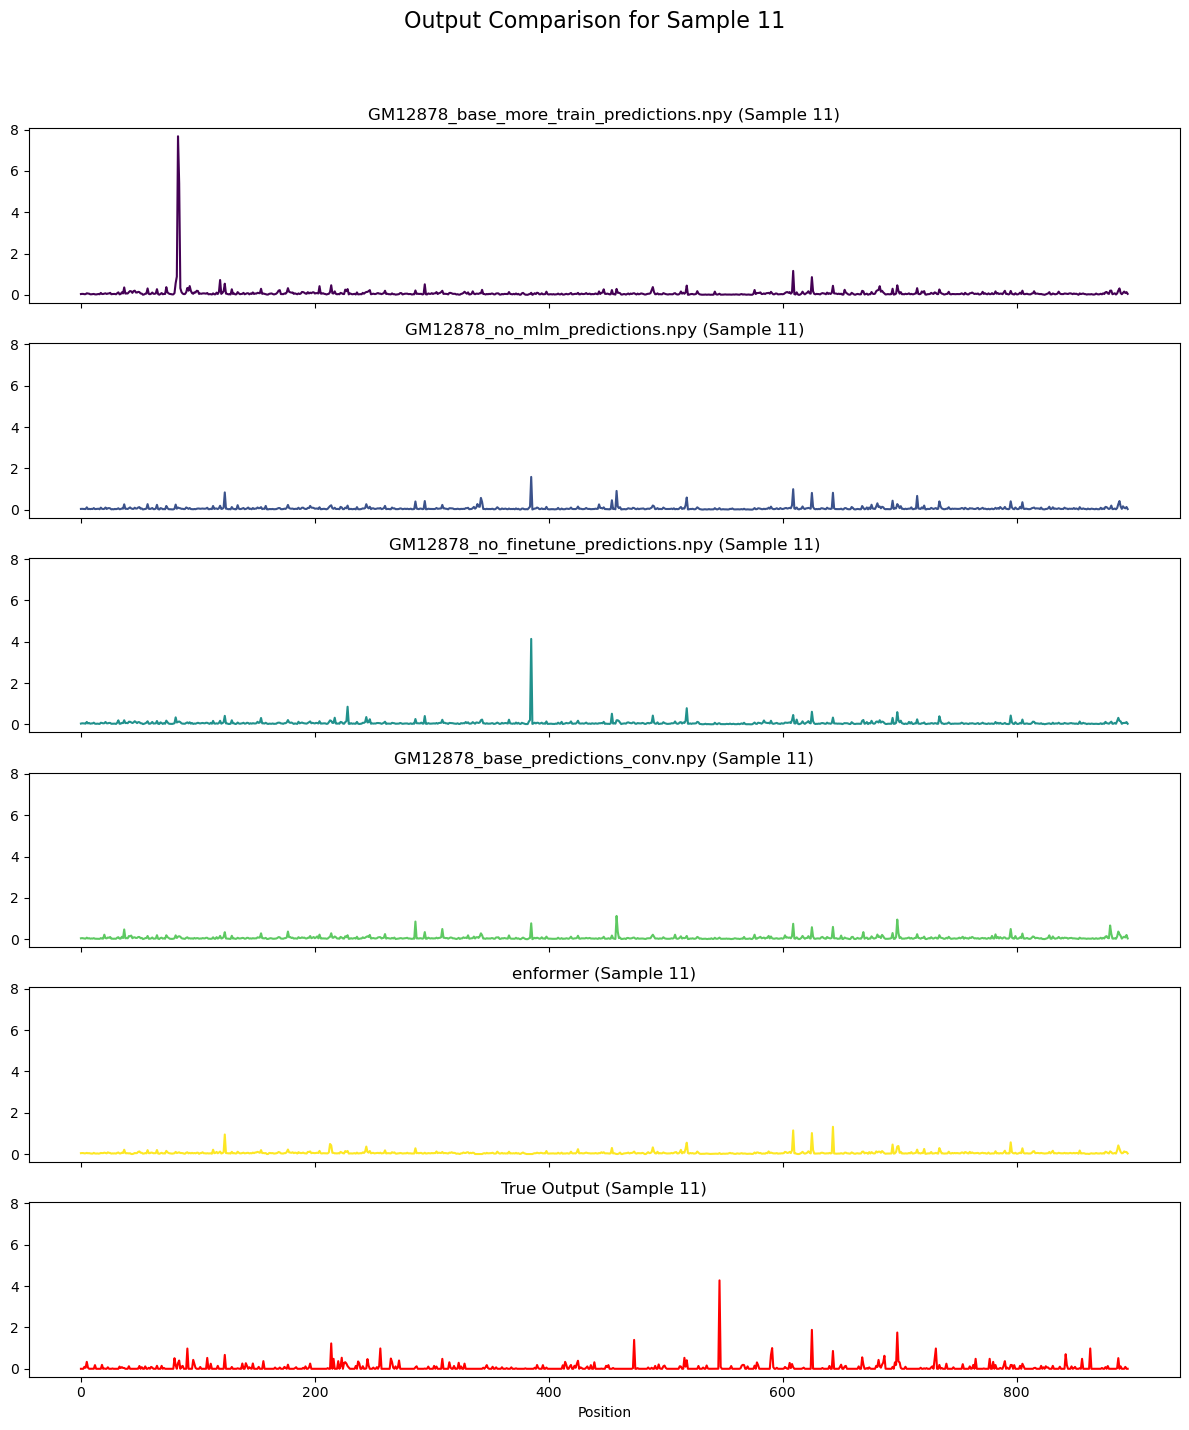

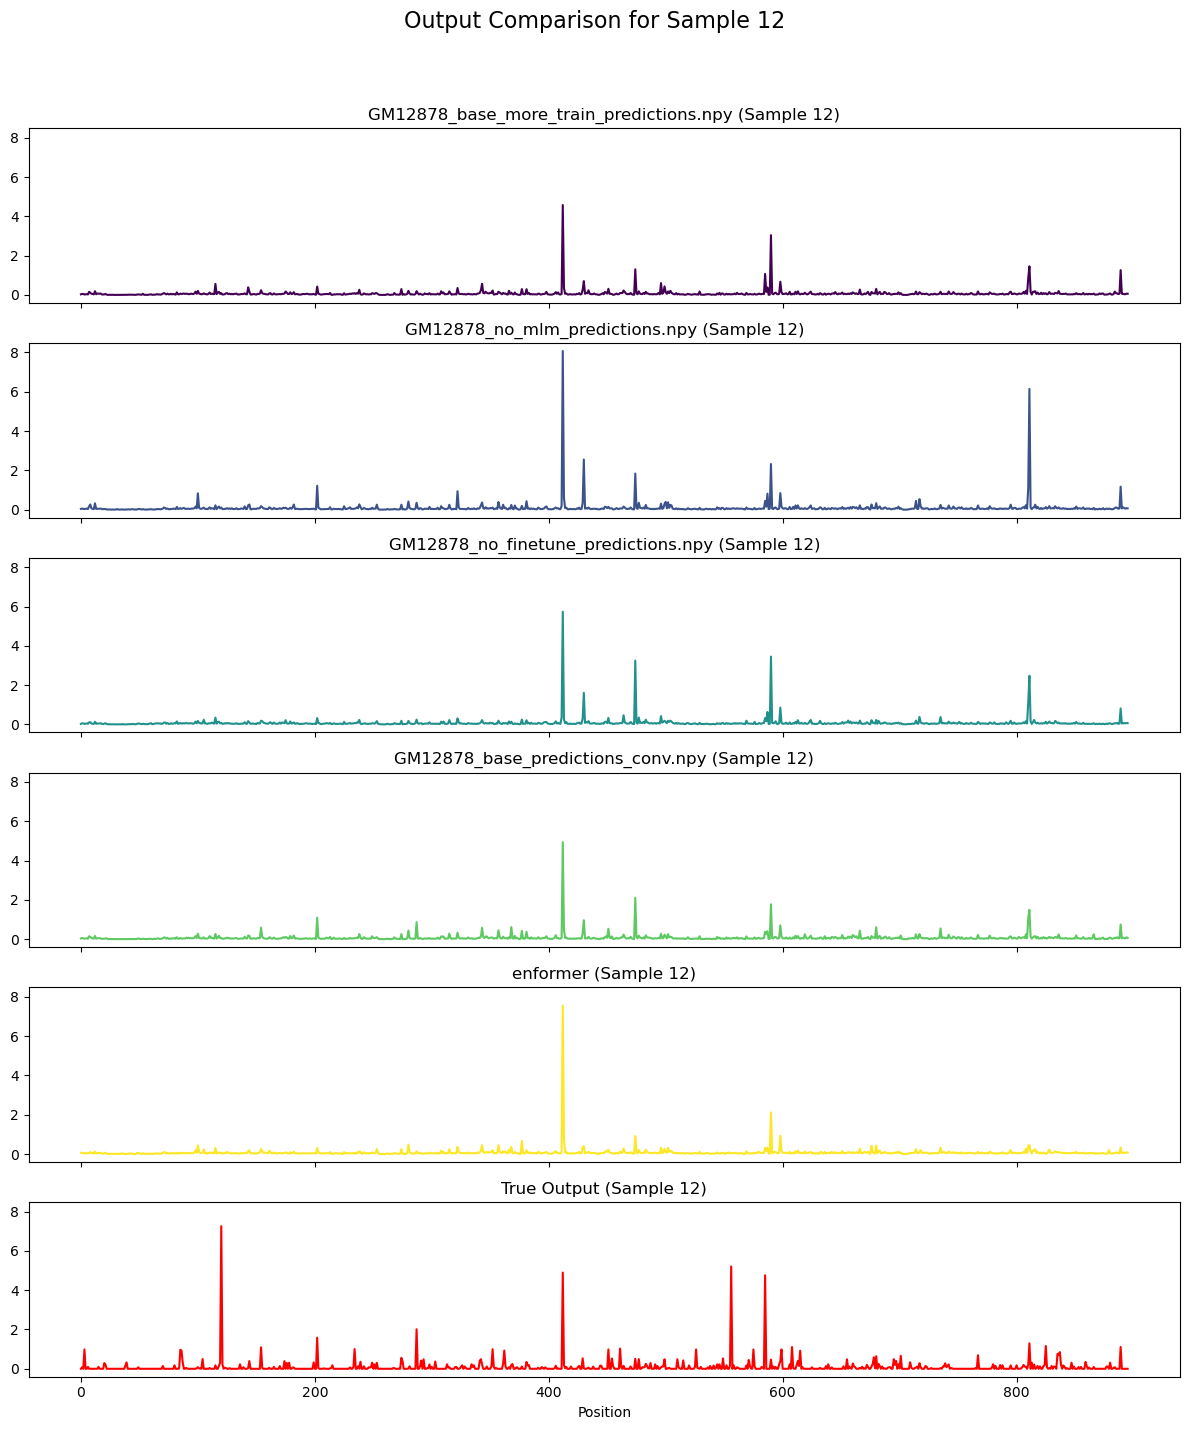

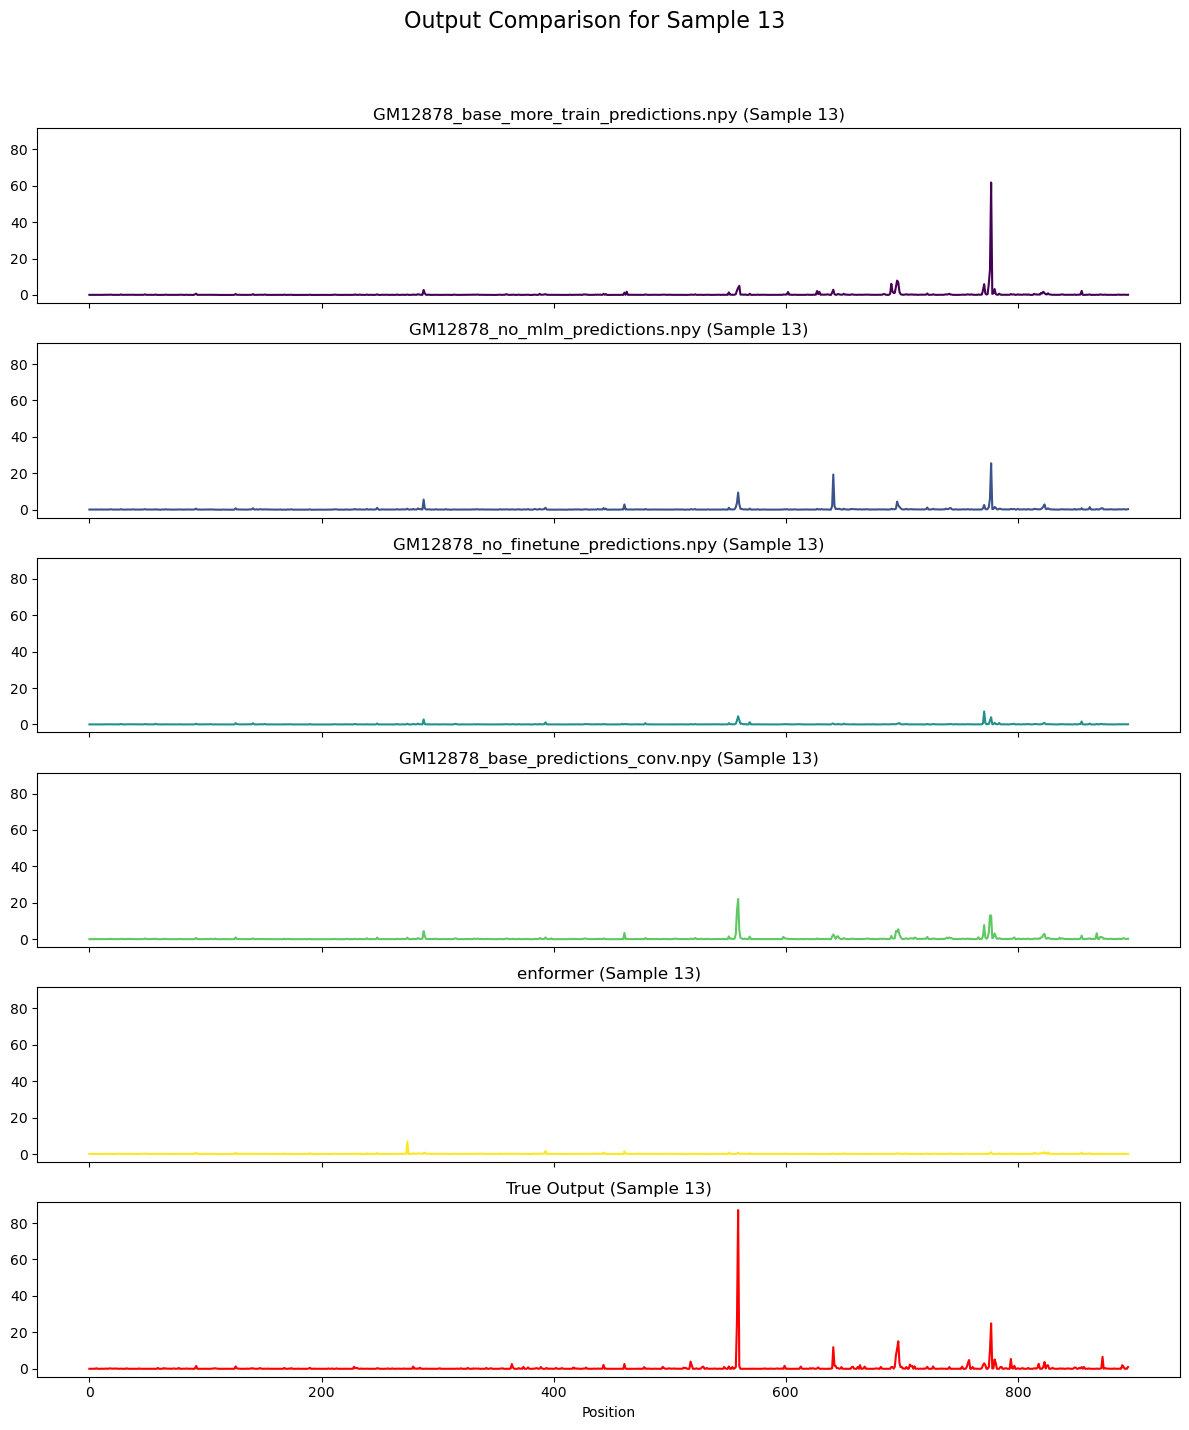

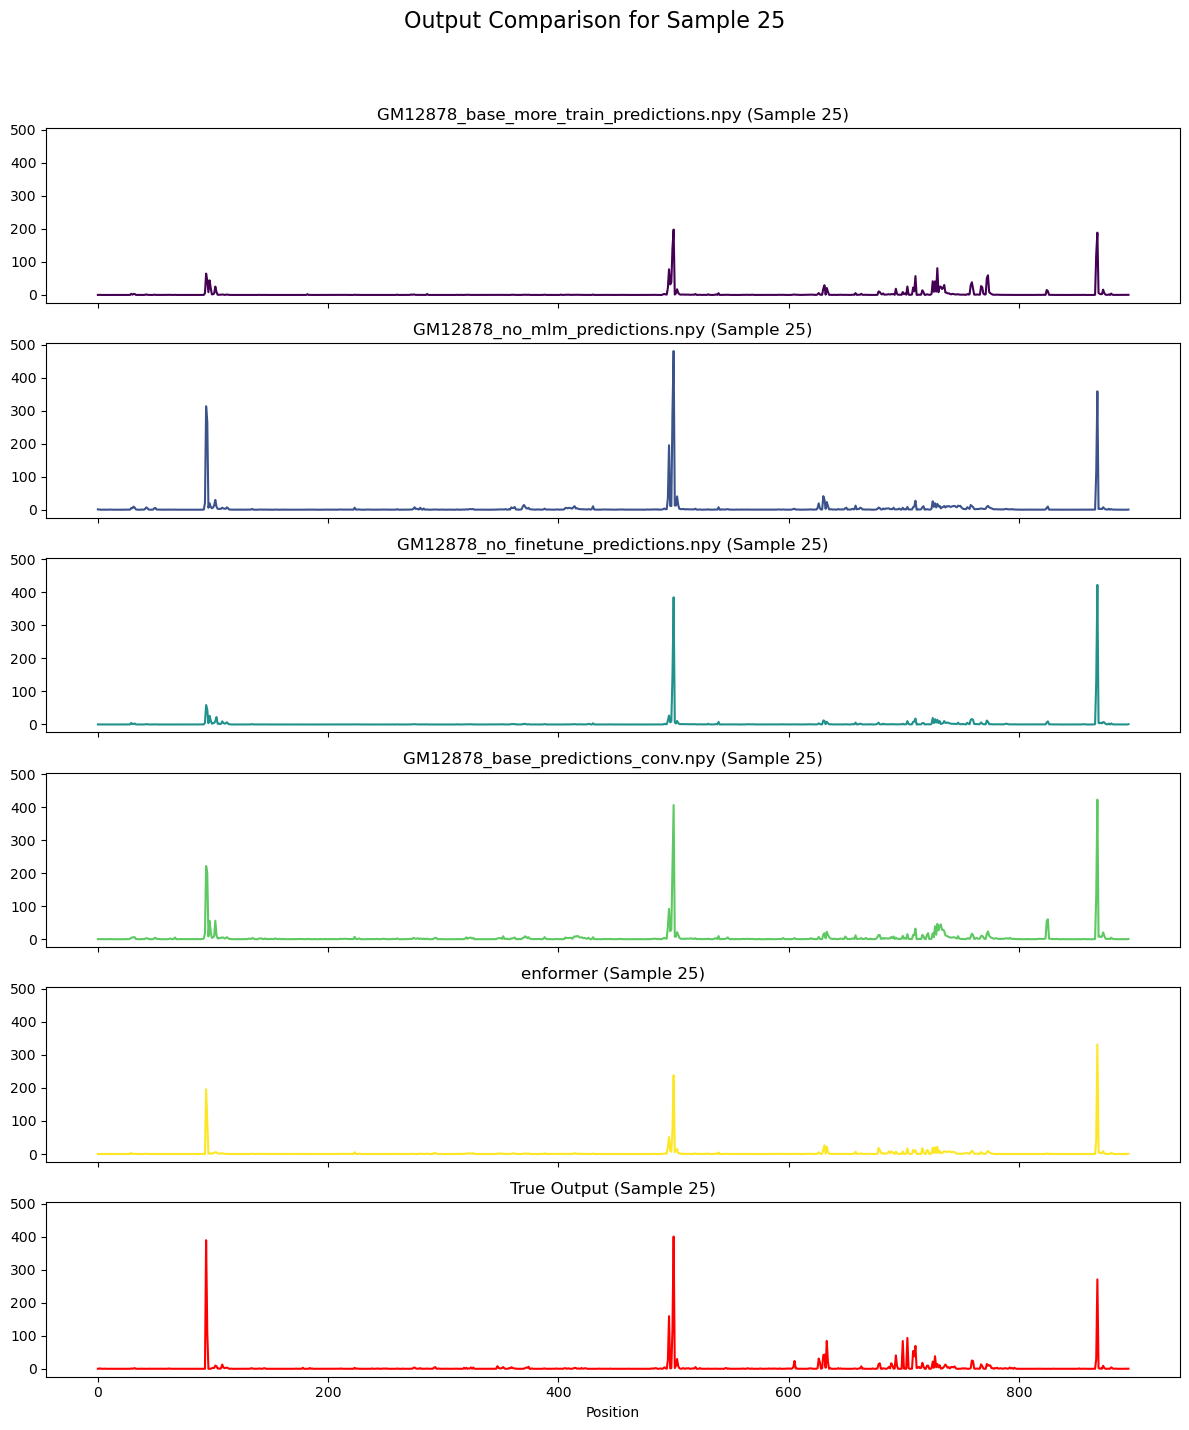

In [20]:
sample_ids = [11,12,13,25]  # list of sample indices you want to plot
plot_output_tracks(sample_ids, preds, t1)

# And doing it for RNA seq

In [1]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNN
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

#set it so only device 3 is seen

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

#set it so only device 3 is seen
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

#edit evals class
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask,exp) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            (x,y),(seq_unmask,acc_unmask,exp) = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
        
        return x1, exp

In [2]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-19/10-41-03-067101/checkpoints/last.ckpt'
evals = Evals(ckpt_path, load_data=False)

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [5]:
len(evals.dataset)

6888

In [7]:
evals.cfg['dataset']

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
 'length': 524288,
 'shift_sequences': 0,
 'load_in': False,
 'rc_aug': False,
 'mlm': 0,
 'acc_mlm': 0,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'additional_data': '/data1/lesliec/sarthak/data/borzoi/borzoi.zarr',
 'sequences_bed_file': '/data1/lesliec/sarthak/data/DK_zarr/sequences_borzoi_fold3-4.bed',
 'additional_data_idxs': '/data1/lesliec/sarthak/data/DK_zarr/idx_lists/gm12878_RNA.json',
 'split': 'test',
 'evaluating': True}

In [ ]:
evals.cfg['decoder'] #wait d output is 1 here??

{'yshape': 196608,
 'bin_size': 32,
 'conjoin_train': False,
 'conjoin_test': False,
 'convolutions': True,
 'd_model': 256,
 'd_output': 1}

In [8]:
#it just multitasks, so this should be relatively straightforward! Also using the borzoi bed file!

out = evals.dataset[0]
print(out[0][0].shape, out[0][1].shape)
print(out[1][0].shape, out[1][1].shape, out[1][2].shape)

torch.Size([6, 524288]) torch.Size([2, 524288])
torch.Size([524288, 6]) torch.Size([524288, 2]) (6144, 30)


In [ ]:
torch.allclose(out[0][0], out[1][0].transpose(1,0)), torch.allclose(out[0][1], out[1][1].transpose(1,0))
#confirms MLM not doing anything, nothing masked!

(True, True)

In [ ]:
#then it predicts these output tracks of length 6k and 30 long!
#now let's see!

out = evals(0)
out[0].shape, out[1].shape
#I guess we need to retrain the model, its output is shape 1...
#that's absolutely a concern lmao!

(torch.Size([1, 6144, 1]), (6144, 30))

In [15]:
#let's see how loss was calculated
evals.decoder.convolutions

True

In [3]:
(seq,acc),(seq_unmask,acc_unmask,exp) = evals.dataset[0]
            
x = seq.unsqueeze(0)
y = acc.unsqueeze(0)

x,y = x.to(evals.device), y.to(evals.device)

with torch.no_grad():
    x1 = evals.encoder(x,y)
    x1,_ = evals.backbone(x1)
    print(x1.shape)
    # x1 = evals.decoder(x1)

torch.Size([1, 524288, 256])


In [4]:
with torch.no_grad():
    y1 = evals.decoder.final_pointwise(x1)
    print('after pointwise:', y1.shape)
    startidx = y1.shape[1]//2 - evals.decoder.yshape//2
    endidx = startidx + evals.decoder.yshape

    y2 = y1[:,startidx:endidx,:] #cuts it to size yshape which is the middle 896, not the full 1536
    print('after cut:', y2.shape)
    x_permute = y2.permute(0,2,1)
    print('after permute:', x_permute.shape)
    # x_pooled = F.avg_pool1d(x_permute, kernel_size=self.bin_size, stride=self.bin_size)
    x_pooled = evals.decoder.pool(x_permute)
    print('post pool:', x_pooled.shape)
    x = x_pooled.permute(0,2,1)
    print('after permute:', x.shape)
    x = evals.decoder.output_transform(x)
    print('after transform:', x.shape)

after pointwise: torch.Size([1, 524288, 512])
after cut: torch.Size([1, 196608, 512])
after permute: torch.Size([1, 512, 196608])
post pool: torch.Size([1, 512, 6144])
after permute: torch.Size([1, 6144, 512])
after transform: torch.Size([1, 6144, 1])


In [5]:
#yeah so this is a problem lol. LEt's see why it doesn't throw an issue
# true_vals = torch.zeros((1, 6144, 30), dtype=torch.float32).to(evals.device)
true_vals = torch.tensor(exp).unsqueeze(0).to(evals.device)
true_vals.shape

torch.Size([1, 6144, 30])

In [6]:
x.shape

torch.Size([1, 6144, 1])

In [ ]:
import torch.nn.functional as F
#get softplus of x
tempx = F.softplus(x)
poisson_loss = F.poisson_nll_loss(tempx, true_vals, log_input=False, full=False)
poisson_loss
#so this output is poisson loss averaged over all the elements. This is not good of course!!
#it was broadcasting lmfao!!!

tensor(0.2213, device='cuda:0')